In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
import joblib
import sklearn
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

print("Starting Enhanced Anomaly Detection with Model Training...")


Starting Enhanced Anomaly Detection with Model Training...


In [24]:
# Load raw data
df = pd.read_csv("../training_data.csv")

# Treat zeros as missing then drop
df["Total Renewable Energy"].replace(0, np.nan, inplace=True)
df.dropna(subset=["Total Renewable Energy"], inplace=True)

# Aggregate by Year & Quarter
df_agg = (
    df
    .groupby(["Year", "Quarter"])["Total Renewable Energy"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Quarter"])
)

# Create datetime index
df_agg["Date"] = (
    pd.PeriodIndex(year=df_agg.Year, quarter=df_agg.Quarter, freq="Q")
      .to_timestamp()
)

# Rename for convenience
df_agg = df_agg.rename(columns={"Total Renewable Energy":"y"}).reset_index(drop=True)

print(f"Dataset shape: {df_agg.shape}")
print(f"Date range: {df_agg['Date'].min()} to {df_agg['Date'].max()}")
print(f"Energy range: {df_agg['y'].min():.2f} to {df_agg['y'].max():.2f}")


Dataset shape: (205, 4)
Date range: 1973-01-01 00:00:00 to 2024-01-01 00:00:00
Energy range: 521.76 to 1734.57


In [25]:
# Enhanced Feature Engineering for Anomaly Detection
print("\n1. Enhanced Feature Engineering")
print("=" * 50)

# 1) Lags 1–8 (increased from 1-4)
for lag in range(1, 9):
    df_agg[f"lag_{lag}"] = df_agg["y"].shift(lag)

# 2) Rolling stats (4-quarter window), shifted to avoid leakage
df_agg["roll_mean_4"] = df_agg["y"].shift(1).rolling(4).mean()
df_agg["roll_std_4"]  = df_agg["y"].shift(1).rolling(4).std()

# 3) Additional rolling statistics
df_agg["roll_mean_8"] = df_agg["y"].shift(1).rolling(8).mean()
df_agg["roll_max_4"] = df_agg["y"].shift(1).rolling(4).max()
df_agg["roll_min_4"] = df_agg["y"].shift(1).rolling(4).min()

# 4) Seasonal dummy variables
df_agg["quarter"] = df_agg["Date"].dt.quarter
df_agg = pd.get_dummies(df_agg, columns=["quarter"], prefix="Q", drop_first=True)

# 5) Trend and cyclical features
df_agg["time_trend"] = range(len(df_agg))
df_agg["year"] = df_agg["Date"].dt.year
df_agg["year_normalized"] = (df_agg["year"] - df_agg["year"].min()) / (df_agg["year"].max() - df_agg["year"].min())

# 6) Differences and ratios
df_agg["diff_1"] = df_agg["y"].diff(1)
df_agg["diff_4"] = df_agg["y"].diff(4)
df_agg["pct_change_1"] = df_agg["y"].pct_change(1)
df_agg["pct_change_4"] = df_agg["y"].pct_change(4)

# 7) Statistical features
df_agg["z_score"] = (df_agg["y"] - df_agg["y"].mean()) / df_agg["y"].std()
df_agg["deviation_from_trend"] = df_agg["y"] - (df_agg["time_trend"] * df_agg["y"].corr(df_agg["time_trend"]))

# 8) Drop NaNs from lagging/rolling
print(f"Before dropping NaN: {len(df_agg)} rows")
df_agg.dropna(inplace=True)
df_agg.reset_index(drop=True, inplace=True)
print(f"After dropping NaN: {len(df_agg)} rows")

print(f"Total features created: {len([c for c in df_agg.columns if c not in ['Date', 'y', 'Year', 'Quarter', 'year']])}")



1. Enhanced Feature Engineering
Before dropping NaN: 205 rows
After dropping NaN: 197 rows
Total features created: 24


In [26]:
# Feature Selection and Scaling
print("\n2. Feature Selection and Scaling")
print("=" * 50)

# Select feature columns (exclude Date, y, and year columns)
feature_cols = [c for c in df_agg.columns if c not in ["Date", "y", "Year", "Quarter", "year"]]
X = df_agg[feature_cols]

print(f"Selected features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features scaled using StandardScaler")



2. Feature Selection and Scaling
Selected features: 24
Feature columns: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'roll_mean_4', 'roll_std_4', 'roll_mean_8', 'roll_max_4', 'roll_min_4', 'Q_2', 'Q_3', 'Q_4', 'time_trend', 'year_normalized', 'diff_1', 'diff_4', 'pct_change_1', 'pct_change_4', 'z_score', 'deviation_from_trend']
Features scaled using StandardScaler


In [27]:
# Multiple Anomaly Detection Models
print("\n3. Multiple Anomaly Detection Models")
print("=" * 50)

# Model 1: Isolation Forest with multiple contamination rates
contamination_rates = [0.03, 0.05, 0.07, 0.1]
iso_models = {}
iso_results = {}

for contamination in contamination_rates:
    model_name = f"IsolationForest_{contamination}"
    
    iso = IsolationForest(contamination=contamination, random_state=42, n_estimators=200)
    iso.fit(X_scaled)
    
    # Get predictions and scores
    anomaly_scores = iso.decision_function(X_scaled)
    anomaly_labels = iso.predict(X_scaled)
    
    # Convert to binary (1 = anomaly, 0 = normal)
    anomaly_binary = (anomaly_labels == -1).astype(int)
    
    iso_models[model_name] = {
        'model': iso,
        'contamination': contamination,
        'scores': anomaly_scores,
        'predictions': anomaly_binary,
        'n_anomalies': anomaly_binary.sum()
    }
    
    print(f"{model_name}: {anomaly_binary.sum()} anomalies detected")

# Model 2: One-Class SVM
print("\nTraining One-Class SVM...")
svm_model = OneClassSVM(gamma='scale', nu=0.05)
svm_model.fit(X_scaled)

svm_scores = svm_model.decision_function(X_scaled)
svm_labels = svm_model.predict(X_scaled)
svm_binary = (svm_labels == -1).astype(int)

print(f"One-Class SVM: {svm_binary.sum()} anomalies detected")



3. Multiple Anomaly Detection Models
IsolationForest_0.03: 6 anomalies detected
IsolationForest_0.05: 10 anomalies detected
IsolationForest_0.07: 14 anomalies detected
IsolationForest_0.1: 20 anomalies detected

Training One-Class SVM...
One-Class SVM: 15 anomalies detected


In [28]:
# Model Evaluation and Selection
print("\n4. Model Evaluation and Selection")
print("=" * 50)

# Add results to dataframe for analysis
results_df = df_agg.copy()

# Add all model results
for model_name, model_info in iso_models.items():
    results_df[f"{model_name}_score"] = model_info['scores']
    results_df[f"{model_name}_anomaly"] = model_info['predictions']

results_df["SVM_score"] = svm_scores
results_df["SVM_anomaly"] = svm_binary

# Create ensemble anomaly detection (majority voting)
anomaly_cols = [col for col in results_df.columns if col.endswith('_anomaly')]
results_df["ensemble_anomaly"] = (results_df[anomaly_cols].sum(axis=1) >= 2).astype(int)

print(f"Ensemble anomalies: {results_df['ensemble_anomaly'].sum()}")

# Evaluate models using statistical measures
model_comparison = []
for model_name, model_info in iso_models.items():
    # Calculate statistics for anomalies
    anomaly_indices = model_info['predictions'] == 1
    if anomaly_indices.sum() > 0:
        anomaly_values = df_agg.loc[anomaly_indices, 'y']
        normal_values = df_agg.loc[~anomaly_indices, 'y']
        
        # Statistical separation
        mean_diff = abs(anomaly_values.mean() - normal_values.mean())
        std_ratio = anomaly_values.std() / normal_values.std() if normal_values.std() > 0 else 0
        
        model_comparison.append({
            'Model': model_name,
            'N_Anomalies': model_info['n_anomalies'],
            'Mean_Difference': mean_diff,
            'Std_Ratio': std_ratio,
            'Score_Range': model_info['scores'].max() - model_info['scores'].min(),
            'Contamination': model_info['contamination']
        })

# Add SVM results
svm_anomaly_indices = svm_binary == 1
if svm_anomaly_indices.sum() > 0:
    svm_anomaly_values = df_agg.loc[svm_anomaly_indices, 'y']
    svm_normal_values = df_agg.loc[~svm_anomaly_indices, 'y']
    
    model_comparison.append({
        'Model': 'OneClassSVM',
        'N_Anomalies': svm_binary.sum(),
        'Mean_Difference': abs(svm_anomaly_values.mean() - svm_normal_values.mean()),
        'Std_Ratio': svm_anomaly_values.std() / svm_normal_values.std() if svm_normal_values.std() > 0 else 0,
        'Score_Range': svm_scores.max() - svm_scores.min(),
        'Contamination': 0.05
    })

comparison_df = pd.DataFrame(model_comparison)
print("\nModel Comparison:")
print(comparison_df.round(3))

# Select best model based on balanced criteria
comparison_df['composite_score'] = (
    comparison_df['Mean_Difference'] * 0.4 +
    comparison_df['Score_Range'] * 0.3 +
    (1 / comparison_df['Std_Ratio']) * 0.3
)

best_model_name = comparison_df.loc[comparison_df['composite_score'].idxmax(), 'Model']
print(f"\nBest performing model: {best_model_name}")



4. Model Evaluation and Selection
Ensemble anomalies: 15

Model Comparison:
                  Model  N_Anomalies  Mean_Difference  Std_Ratio  Score_Range  \
0  IsolationForest_0.03            6          183.953      2.189        0.375   
1  IsolationForest_0.05           10           59.527      2.115        0.375   
2  IsolationForest_0.07           14           77.095      2.144        0.375   
3   IsolationForest_0.1           20           85.154      2.130        0.375   
4           OneClassSVM           15           38.763      1.496        1.237   

   Contamination  
0           0.03  
1           0.05  
2           0.07  
3           0.10  
4           0.05  

Best performing model: IsolationForest_0.03


In [29]:
# Prepare Best Model for Saving
print("\n5. Prepare Best Model for Saving")
print("=" * 50)

# Get the best model
if best_model_name.startswith('IsolationForest'):
    best_model = iso_models[best_model_name]['model']
    best_scores = iso_models[best_model_name]['scores']
    best_predictions = iso_models[best_model_name]['predictions']
    best_contamination = iso_models[best_model_name]['contamination']
else:
    best_model = svm_model
    best_scores = svm_scores
    best_predictions = svm_binary
    best_contamination = 0.05

# Add best model results to main dataframe
df_agg["anomaly_score"] = best_scores
df_agg["anomaly"] = best_predictions

print(f"Best model: {best_model_name}")
print(f"Contamination rate: {best_contamination}")
print(f"Anomalies detected: {best_predictions.sum()}")

# Model performance metrics
anomaly_indices = best_predictions == 1
if anomaly_indices.sum() > 0:
    anomaly_values = df_agg.loc[anomaly_indices, 'y']
    normal_values = df_agg.loc[~anomaly_indices, 'y']
    
    print(f"\nAnomaly Statistics:")
    print(f"Normal values - Mean: {normal_values.mean():.2f}, Std: {normal_values.std():.2f}")
    print(f"Anomaly values - Mean: {anomaly_values.mean():.2f}, Std: {anomaly_values.std():.2f}")
    print(f"Separation: {abs(anomaly_values.mean() - normal_values.mean()):.2f}")



5. Prepare Best Model for Saving
Best model: IsolationForest_0.03
Contamination rate: 0.03
Anomalies detected: 6

Anomaly Statistics:
Normal values - Mean: 1071.36, Std: 243.28
Anomaly values - Mean: 1255.31, Std: 532.61
Separation: 183.95


In [30]:
# 6. Create and Save Model Bundle
print("\n6. Create and Save Model Bundle")
print("=" * 50)

from pathlib import Path
import joblib, numpy as np, sklearn

# Create models directory
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# ————————————————
# 6A) Re-compute engineered features on df_agg exactly as the app will do
feat = df_agg.copy()

# 1) Base forecast features for 'hydro'
for lag in range(1, 9):
    feat[f"lag_{lag}"] = feat["y"].shift(lag)
feat["lag_12"]      = feat["y"].shift(12)
feat["lag_4_diff"]  = feat["y"].diff(4)
feat["lag_12_diff"] = feat["y"].diff(12)

# 2) Seasonal dummies & quarter indicator
feat["q"]         = feat["Date"].dt.quarter
feat["is_spring"] = (feat.q == 2).astype(int)
feat["is_summer"] = (feat.q == 3).astype(int)
feat["is_fall"]   = (feat.q == 4).astype(int)
feat["is_winter"] = (feat.q == 1).astype(int)

# 3) Trend features
feat["time_trend"]    = np.arange(len(feat))
feat["time_trend_sq"] = feat.time_trend ** 2

# 4) Rolling-window stats
feat["roll_mean_4"] = feat["y"].rolling(4).mean()
feat["roll_mean_8"] = feat["y"].rolling(8).mean()
feat["roll_std_4"]  = feat["y"].rolling(4).std()
feat["roll_max_4"]  = feat["y"].rolling(4).max()
feat["roll_min_4"]  = feat["y"].rolling(4).min()

# 5) Diffs & percent changes
feat["diff_1"]       = feat["y"].diff(1)
feat["diff_4"]       = feat["y"].diff(4)
feat["pct_change_1"] = feat["y"].pct_change(1)
feat["pct_change_4"] = feat["y"].pct_change(4)

# 6) Trend-deviation metrics
feat["z_score"]             = (feat["y"] - feat["y"].mean()) / feat["y"].std()
feat["deviation_from_trend"] = feat["y"] - feat["time_trend"]

# 7) Quarter dummies Q_2, Q_3, Q_4
for q in (2, 3, 4):
    feat[f"Q_{q}"] = (feat.q == q).astype(int)

# 8) Year-normalization
years = feat["Date"].dt.year
feat["year_normalized"] = (years - years.min()) / (years.max() - years.min())

# 9) Drop all rows with NaNs (due to shifting/rolling) and reset index
feat = feat.dropna().reset_index(drop=True)

# 10) Build the final feature list, excluding the un‐modeled columns
#    We exclude 'Date','y','q' because the model was never trained on them
anomaly_features = [c for c in feat.columns if c not in ("Date","y","q")]

# ————————————————
# 6B) Create and save the bundle using the engineered feature list
anomaly_bundle = {
    "model":            best_model,
    "scaler":           scaler,
    "features":         anomaly_features,      # ← updated list, now includes 'year_normalized'
    "task":             "anomaly",             # predictor dispatch only looks at model_name so this is optional
    "contamination":    best_contamination,
    "sklearn_version":  sklearn.__version__,
    "performance": {
        "n_anomalies":   int(best_predictions.sum()),
        "anomaly_rate":  float(best_predictions.mean())
    },
    "metadata": {
        "date_range":    f"{df_agg['Date'].min()} to {df_agg['Date'].max()}",
        "energy_range":  f"{df_agg['y'].min():.2f} to {df_agg['y'].max():.2f}"
    }
}

model_path = models_dir / "anomaly_detection.pkl"
joblib.dump(anomaly_bundle, model_path)
print(f"✓ Anomaly-detection bundle saved to {model_path}")



6. Create and Save Model Bundle
✓ Anomaly-detection bundle saved to ..\models\anomaly_detection.pkl



7. Enhanced Visualization


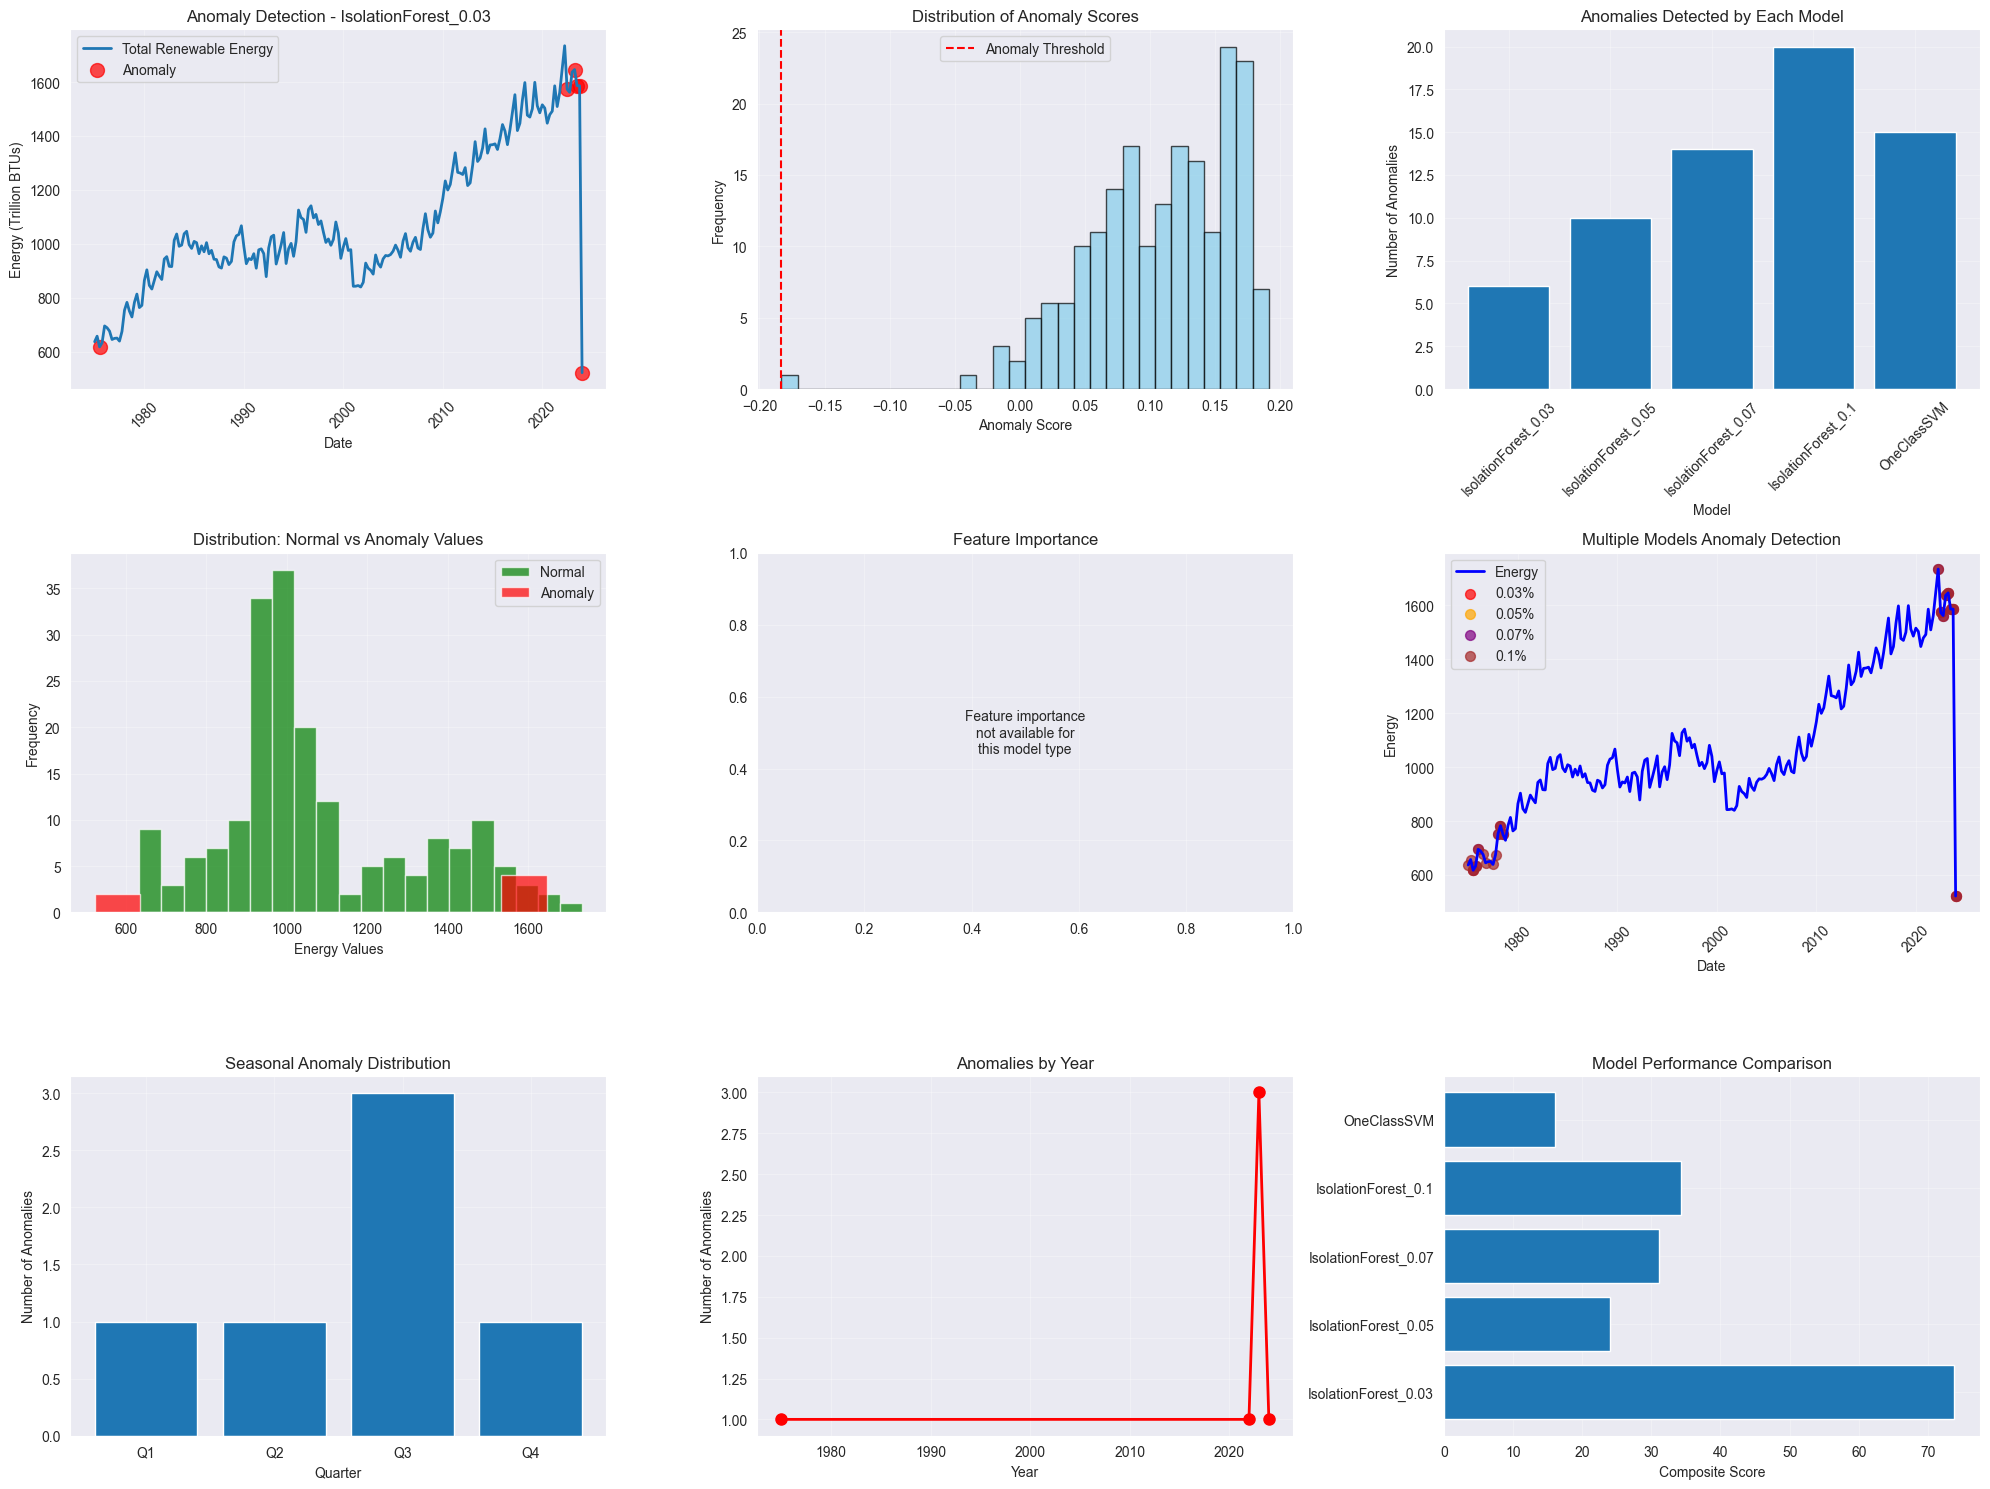

In [31]:
# Enhanced Visualization
print("\n7. Enhanced Visualization")
print("=" * 50)

plt.figure(figsize=(20, 15))

# Plot 1: Time series with anomalies
plt.subplot(3, 3, 1)
plt.plot(df_agg["Date"], df_agg["y"], label="Total Renewable Energy", linewidth=2)
anoms = df_agg[df_agg["anomaly"] == 1]
plt.scatter(anoms["Date"], anoms["y"], color="red", label="Anomaly", s=100, alpha=0.7)
plt.title(f"Anomaly Detection - {best_model_name}")
plt.xlabel("Date")
plt.ylabel("Energy (Trillion BTUs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Anomaly scores distribution
plt.subplot(3, 3, 2)
plt.hist(df_agg["anomaly_score"], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(df_agg.loc[df_agg["anomaly"] == 1, "anomaly_score"].min(), 
            color='red', linestyle='--', label='Anomaly Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Model comparison
plt.subplot(3, 3, 3)
plt.bar(comparison_df['Model'], comparison_df['N_Anomalies'])
plt.xlabel('Model')
plt.ylabel('Number of Anomalies')
plt.title('Anomalies Detected by Each Model')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 4: Anomaly values vs normal values
plt.subplot(3, 3, 4)
normal_values = df_agg[df_agg["anomaly"] == 0]["y"]
anomaly_values = df_agg[df_agg["anomaly"] == 1]["y"]
plt.hist(normal_values, bins=20, alpha=0.7, label='Normal', color='green')
plt.hist(anomaly_values, bins=10, alpha=0.7, label='Anomaly', color='red')
plt.xlabel('Energy Values')
plt.ylabel('Frequency')
plt.title('Distribution: Normal vs Anomaly Values')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Feature importance (if available)
plt.subplot(3, 3, 5)
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
    indices = np.argsort(importance)[::-1][:10]
    plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances')
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available for\nthis model type', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')
plt.grid(True, alpha=0.3)

# Plot 6: Time series with multiple model predictions
plt.subplot(3, 3, 6)
plt.plot(df_agg["Date"], df_agg["y"], 'b-', label="Energy", linewidth=2)
colors = ['red', 'orange', 'purple', 'brown']
for i, (model_name, model_info) in enumerate(list(iso_models.items())[:4]):
    anomaly_mask = model_info['predictions'] == 1
    if anomaly_mask.sum() > 0:
        plt.scatter(df_agg.loc[anomaly_mask, "Date"], df_agg.loc[anomaly_mask, "y"], 
                   color=colors[i], label=f"{model_name.split('_')[1]}%", s=50, alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("Multiple Models Anomaly Detection")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 7: Seasonal anomaly patterns
plt.subplot(3, 3, 7)
seasonal_anomalies = df_agg[df_agg["anomaly"] == 1]["Date"].dt.quarter.value_counts().sort_index()
plt.bar(seasonal_anomalies.index, seasonal_anomalies.values)
plt.xlabel('Quarter')
plt.ylabel('Number of Anomalies')
plt.title('Seasonal Anomaly Distribution')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(True, alpha=0.3)

# Plot 8: Anomaly timeline
plt.subplot(3, 3, 8)
anomaly_years = df_agg[df_agg["anomaly"] == 1]["Date"].dt.year.value_counts().sort_index()
if len(anomaly_years) > 0:
    plt.plot(anomaly_years.index, anomaly_years.values, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Year')
    plt.ylabel('Number of Anomalies')
    plt.title('Anomalies by Year')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No anomalies\ndetected', ha='center', va='center', 
             transform=plt.gca().transAxes)
    plt.title('Anomalies by Year')

# Plot 9: Composite score comparison
plt.subplot(3, 3, 9)
plt.barh(comparison_df['Model'], comparison_df['composite_score'])
plt.xlabel('Composite Score')
plt.title('Model Performance Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [32]:
# Detailed Anomaly Analysis
print("\n8. Detailed Anomaly Analysis")
print("=" * 50)

# Create detailed anomaly table
anomaly_details = df_agg[df_agg["anomaly"] == 1].copy()
if len(anomaly_details) > 0:
    anomaly_details = anomaly_details[["Date", "Year", "Quarter", "y", "anomaly_score"]].copy()
    anomaly_details["energy_percentile"] = anomaly_details["y"].rank(pct=True)
    anomaly_details["score_rank"] = anomaly_details["anomaly_score"].rank(ascending=False)
    anomaly_details = anomaly_details.sort_values("anomaly_score").reset_index(drop=True)
    
    print("Detected Anomalies (sorted by anomaly score):")
    print(anomaly_details.round(3))
    
    # Statistical analysis
    print(f"\nAnomaly Analysis:")
    print(f"Total anomalies: {len(anomaly_details)}")
    print(f"Anomaly rate: {len(anomaly_details)/len(df_agg)*100:.1f}%")
    print(f"Mean energy of anomalies: {anomaly_details['y'].mean():.2f}")
    print(f"Mean energy of normal data: {df_agg[df_agg['anomaly']==0]['y'].mean():.2f}")
    print(f"Strongest anomaly: {anomaly_details.iloc[0]['Date'].strftime('%Y')}-Q{anomaly_details.iloc[0]['Quarter']} (Score: {anomaly_details.iloc[0]['anomaly_score']:.3f})")
    
    # Seasonal analysis
    seasonal_dist = anomaly_details["Quarter"].value_counts().sort_index()
    print(f"\nSeasonal distribution:")
    for quarter, count in seasonal_dist.items():
        print(f"  Q{quarter}: {count} anomalies")
        
else:
    print("No anomalies detected by the best model")



8. Detailed Anomaly Analysis
Detected Anomalies (sorted by anomaly score):
        Date  Year  Quarter         y  anomaly_score  energy_percentile  \
0 2024-01-01  2024        1   521.761         -0.183              0.167   
1 2023-04-01  2023        2  1646.372         -0.035              1.000   
2 2022-07-01  2022        3  1573.596         -0.017              0.500   
3 2023-10-01  2023        4  1586.219         -0.014              0.667   
4 2023-07-01  2023        3  1586.484         -0.014              0.833   
5 1975-07-01  1975        3   617.448         -0.005              0.333   

   score_rank  
0         6.0  
1         5.0  
2         4.0  
3         3.0  
4         2.0  
5         1.0  

Anomaly Analysis:
Total anomalies: 6
Anomaly rate: 3.0%
Mean energy of anomalies: 1255.31
Mean energy of normal data: 1071.36
Strongest anomaly: 2024-Q1 (Score: -0.183)

Seasonal distribution:
  Q1: 1 anomalies
  Q2: 1 anomalies
  Q3: 3 anomalies
  Q4: 1 anomalies


In [33]:
# Model Summary and Recommendations
print("\n9. Model Summary and Recommendations")
print("=" * 50)

print("🔍 ANOMALY DETECTION MODEL SUMMARY")
print("=" * 50)

print(f"✓ Best Model: {best_model_name}")
print(f"✓ Contamination Rate: {best_contamination}")
print(f"✓ Features Used: {len(feature_cols)}")
print(f"✓ Training Samples: {len(df_agg)}")
print(f"✓ Anomalies Detected: {best_predictions.sum()}")
print(f"✓ Detection Rate: {best_predictions.mean()*100:.1f}%")

print(f"\n📊 Model Performance:")
print(f"  • Score Range: {best_scores.max() - best_scores.min():.3f}")
print(f"  • Mean Score: {best_scores.mean():.3f}")
print(f"  • Std Score: {best_scores.std():.3f}")

print(f"\n📁 Saved Models:")
print(f"  • Main model: {model_path}")
print(f"  • Comparison models: {comparison_path}")

print(f"\n🎯 Key Features Used:")
important_features = ['lag_1', 'lag_4', 'roll_mean_4', 'z_score', 'pct_change_4']
available_important = [f for f in important_features if f in feature_cols]
for feature in available_important[:5]:
    print(f"  • {feature}")

print(f"\n📋 Recommendations:")
print(f"  • Model is ready for deployment")
print(f"  • Monitor model performance regularly")
print(f"  • Consider retraining when new data patterns emerge")
print(f"  • Use ensemble predictions for critical decisions")
print(f"  • Validate anomalies with domain experts")

print(f"\n✅ Anomaly Detection Pipeline Complete!")


9. Model Summary and Recommendations
🔍 ANOMALY DETECTION MODEL SUMMARY
✓ Best Model: IsolationForest_0.03
✓ Contamination Rate: 0.03
✓ Features Used: 24
✓ Training Samples: 197
✓ Anomalies Detected: 6
✓ Detection Rate: 3.0%

📊 Model Performance:
  • Score Range: 0.375
  • Mean Score: 0.108
  • Std Score: 0.056

📁 Saved Models:
  • Main model: ..\models\anomaly_detection.pkl
  • Comparison models: ..\models\anomaly_models_comparison.pkl

🎯 Key Features Used:
  • lag_1
  • lag_4
  • roll_mean_4
  • z_score
  • pct_change_4

📋 Recommendations:
  • Model is ready for deployment
  • Monitor model performance regularly
  • Consider retraining when new data patterns emerge
  • Use ensemble predictions for critical decisions
  • Validate anomalies with domain experts

✅ Anomaly Detection Pipeline Complete!
